In [1]:
import os

import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

from src import utils
from components import DatasetLoader, Predictor, Model

/home/younes/venvs/master_/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_loader_ = DatasetLoader(
    train_path="./datasets/masks/train",
    val_path="./datasets/masks/val",
    batch_size=32
)

datasets_.train_loader and datasets_.val_loader to be used!


In [4]:
base_path = "../experiments/checkpoints/cnn_based"
model_names = [file for file in os.listdir(base_path) if file.endswith(".pth")]
print(f"Found {len(model_names)} models\n\t" + "\n\t".join(model_names))

Found 2 models
	encoder_resnet18_epoch_49.pth
	encoder_vgg11_epoch_49.pth


In [9]:
def load_model(base_path, model_name):
    if not model_name.endswith(".pth"):
        raise ValueError("Model is not valid!")
    encoder_name = utils.find_encoder_name(model_name)
    model_ = Model(
        encoder=encoder_name,
        num_classes=len(dataset_loader_.train_dataset.num_classes)
    )
    model_path = os.path.join(base_path, model_name)
    state_dict = torch.load(model_path, map_location=torch.device('cuda'))
    model_.model.load_state_dict(state_dict)

    model_.model.eval()
    return model_

In [10]:
predictions = {
    "encoder_names": [],
    "predictions": []
}
test_path = "datasets/masks/test"
for model_name in model_names:
    predictions["encoder_names"].append(utils.find_encoder_name(model_name))
    model_ = load_model(base_path, model_name)
    predictor_ = Predictor(
        model=model_.model,
        dataset_loader=dataset_loader_,
        device=torch.device('cuda'),
        output_dir="experiments/outputs",
        folder_name="pred_classes"
    )
    predictor_.predict_all(images_path=test_path)
    predictions["predictions"].append(pd.DataFrame(predictor_.results))

ClassificationHead(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [11]:
predictions["miss_classified"] = []
predictions["test_accuracy"] = []
for num, encoder_name in enumerate(predictions["encoder_names"]):
    data = predictions["predictions"][num]
    miss_classified = data[data["label"] != data["prediction"]]
    predictions["miss_classified"].append(miss_classified["label"].value_counts())
    predictions["test_accuracy"].append(accuracy_score(predictions["predictions"][num]["label"], predictions["predictions"][num]["prediction"]))

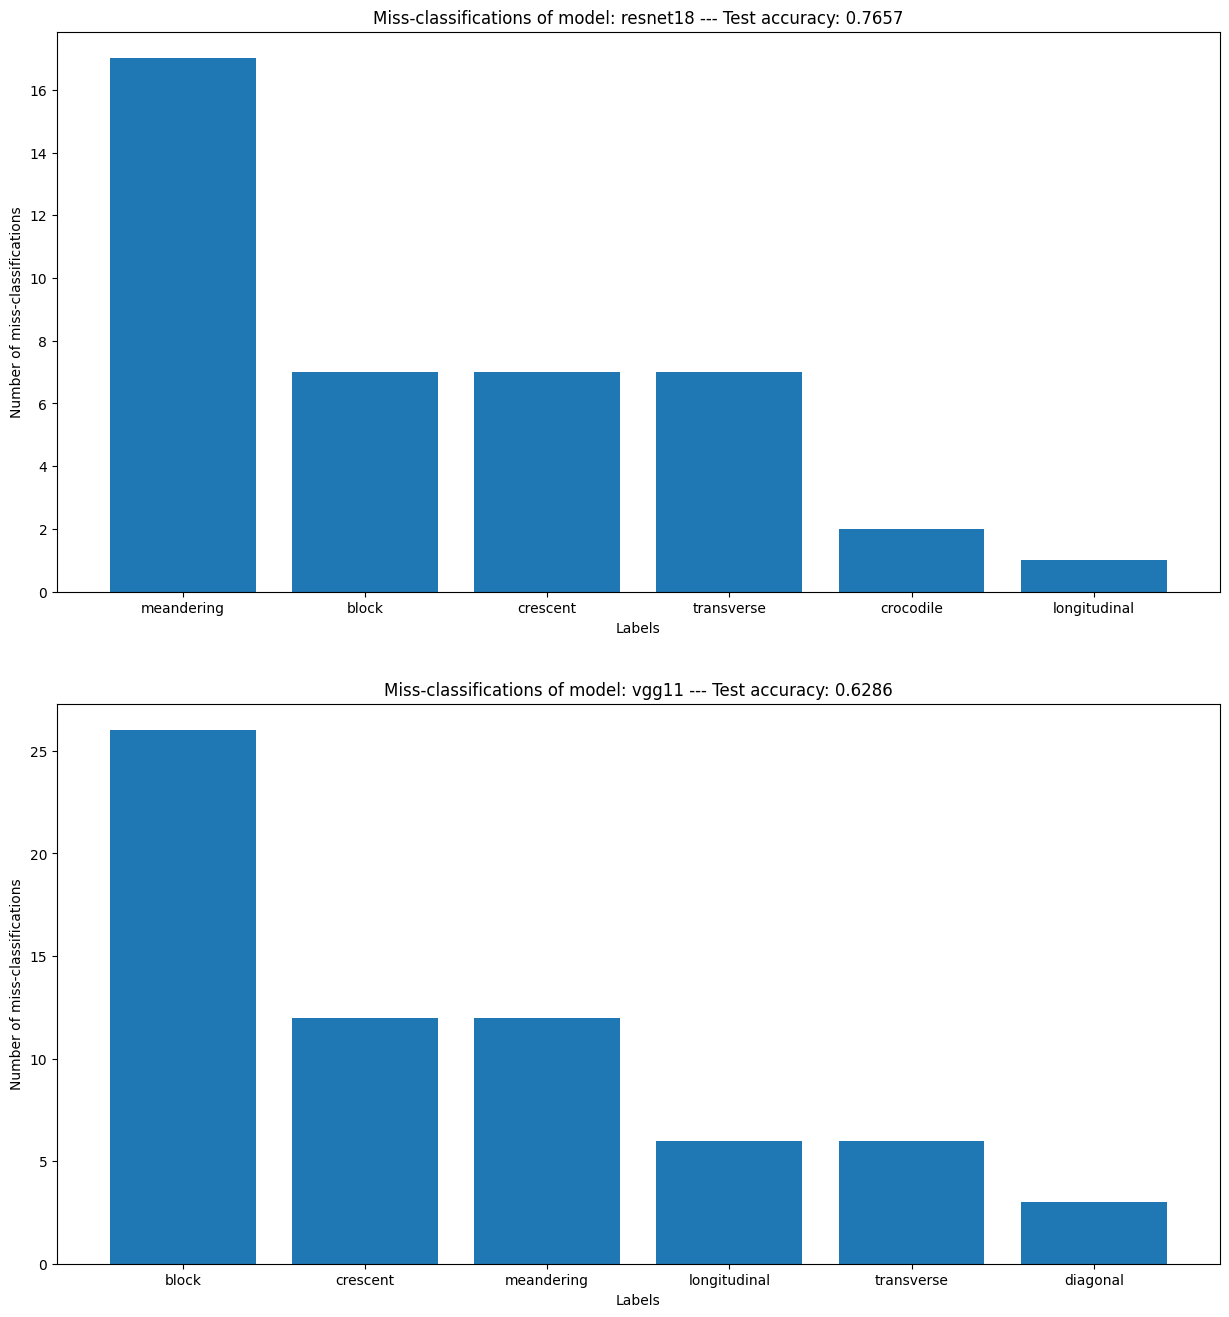

In [12]:
num = len(predictions["predictions"])
fig, ax = plt.subplots(num, 1, figsize=(15, num*8))
for i in range(num):
    ax[i].bar(predictions["miss_classified"][i].index, predictions["miss_classified"][i].values)
    ax[i].set_title(f"Miss-classifications of model: {predictions["encoder_names"][i]} --- Test accuracy: {predictions["test_accuracy"][i]:.4f}")
    ax[i].set_xlabel("Labels")
    ax[i].set_ylabel("Number of miss-classifications")

path = "../experiments/results"
fig.savefig(os.path.join(path, f"miss_classified_{num}.png"), bbox_inches="tight")

In [ ]:
"